In [11]:
cd /Users/prasanna/UNCC_stuff/6162-KnowledgeDiscoveryInDatabases/Project

/Users/prasanna/UNCC_stuff/6162-KnowledgeDiscoveryInDatabases/Project


In [12]:
import pandas as pd
stud_df = pd.read_csv('student-mat-v1.csv')
print(stud_df)

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

     ... goout Dalc  Walc  health  absences  G1  G2

In [34]:
stud_df_orig = pd.read_csv('student-mat-v1.csv')

In [13]:
stud_df.dtypes

school         object
sex            object
age             int64
address        object
famsize        object
Pstatus        object
Medu            int64
Fedu            int64
Mjob           object
Fjob           object
reason         object
guardian       object
traveltime      int64
studytime       int64
failures        int64
schoolsup      object
famsup         object
paid           object
activities     object
nursery        object
higher         object
internet       object
romantic       object
famrel          int64
freetime        int64
goout           int64
Dalc            int64
Walc            int64
health          int64
absences        int64
G1              int64
G2              int64
G3              int64
avgscore      float64
y_binary        int64
dtype: object

#
We may need the category conversion statements only during modeling. For now, they can be just int type.

In [6]:
#stud_df[['school', 'sex', 'address','famsize','Pstatus','Medu','Fedu','Mjob','Fjob','reason','guardian','traveltime','studytime','failures','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic','famrel','freetime','goout','Dalc','Walc','health']] = stud_df[['school', 'sex', 'address','famsize','Pstatus','Medu','Fedu','Mjob','Fjob','reason','guardian','traveltime','studytime','failures','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic','famrel','freetime','goout','Dalc','Walc','health']].astype('category')

In [7]:
#stud_df['y_binary'] = stud_df['y_binary'].astype('category')

In [14]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

In [15]:
def ordinal_encode(series, categories):
  encoder = OrdinalEncoder(categories=categories, dtype=np.int64)
  return encoder.fit_transform(series.values.reshape(-1, 1))

In [16]:
categories_ordenc = {"school": [["GP","MS"]],
                     "sex": [["F", "M"]],
                     "address": [["R", "U"]],
                     "famsize": [["LE3", "GT3"]],
                     "Pstatus": [['A', 'T']],
                     "schoolsup": [["no", "yes"]],
                     "famsup": [["no", "yes"]],
                     "paid": [["no", "yes"]],
                     "activities": [["no", "yes"]],
                     "nursery": [["no", "yes"]],
                     "higher": [["no", "yes"]],
                     "internet": [["no", "yes"]],
                     "romantic": [["no", "yes"]],
                     }

for column, category in categories_ordenc.items():
  stud_df[column] = ordinal_encode(stud_df[column], category)

In [17]:
def onehot_encode(data, column, categories):
  encoder = OneHotEncoder(categories=categories, drop="first", sparse=False, dtype=np.int64)
  encoded_features = encoder.fit_transform(data[column].values.reshape(-1, 1))
  encoder.transform(data[column].values.reshape(-1, 1))

  data = data.drop(labels=column, axis=1)

  for j, category in enumerate(categories[0][1:]):
    category_column_name = "{}_{}".format(column, category)
    data[category_column_name] = encoded_features[:, j]

  return data

In [18]:
categories_hotenc = {"Fjob": [["other", "teacher", "health", "services", 'at_home']],
                     "Mjob": [["other", "teacher", "health", "services", 'at_home']],
                     "reason": [["other", "home", "reputation", "course"]],
                     "guardian": [["other", "mother", "father"]]}

for column, category in categories_hotenc.items():
  stud_df = onehot_encode(stud_df, column, category)

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

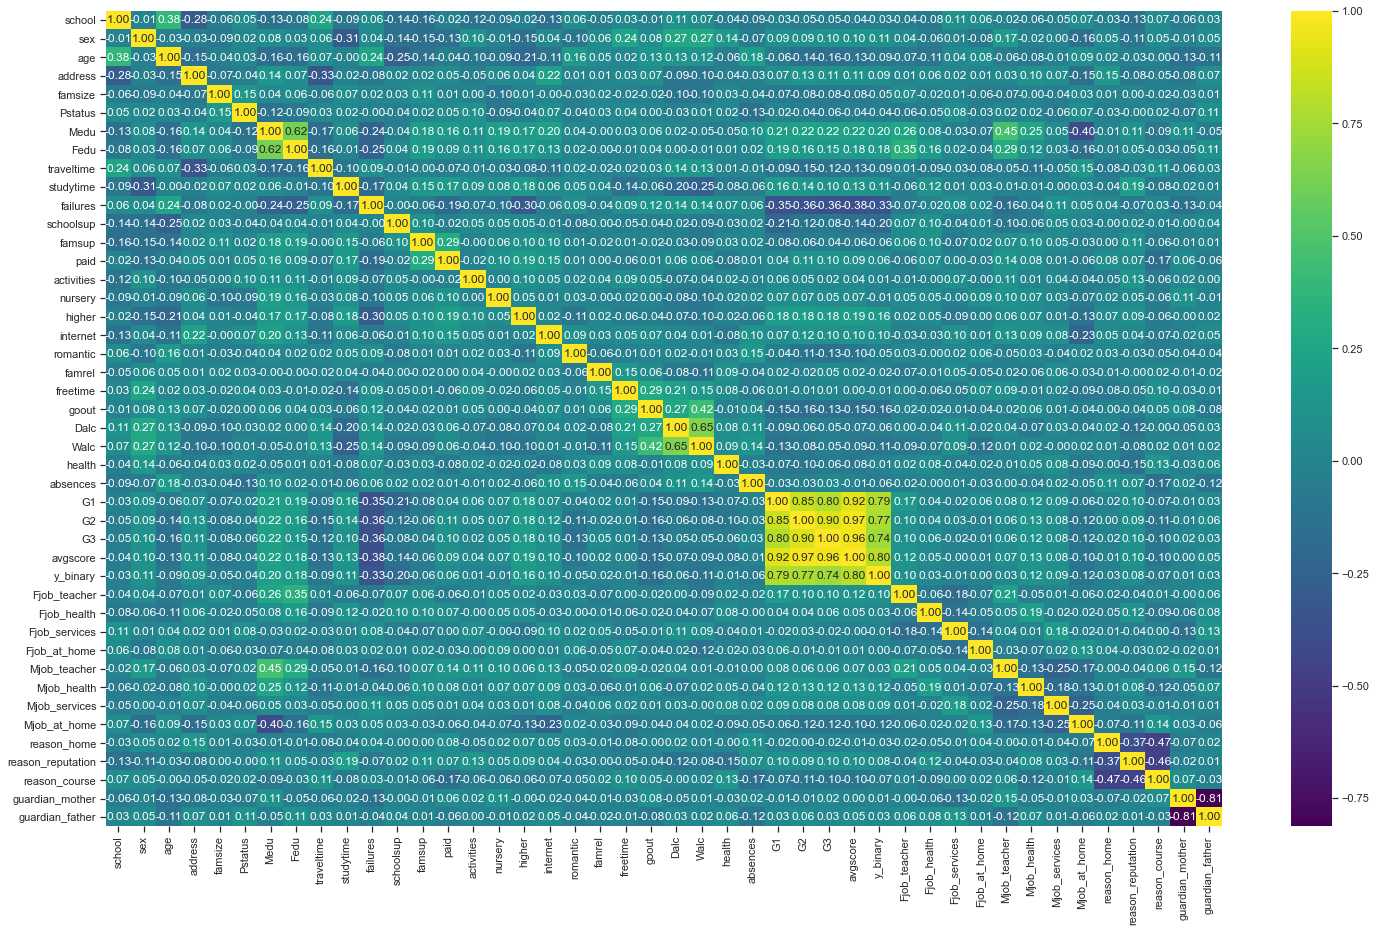

In [21]:
fig, ax = plt.subplots(figsize=(25, 15))

ax = sns.heatmap(stud_df.corr(), annot=True, fmt=".2f", cmap="viridis", ax=ax)
plt.show()

From the correlation above avgscore seems to have some relationship with the following

4. failures (- high)
5. Medu
6. Fedu
7. higher (0.19)
8. Fjob_teacher
9. goout (-)



### AVGScore Vs. Failures
With higher number of failures, the chances of gettin a higher final avgscore diminishes. Students with 3 failures don't seem to cross the 50% threshold.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


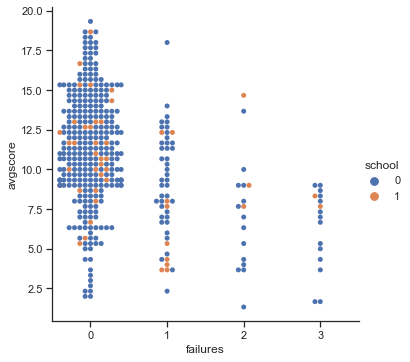

In [28]:
sns.catplot(data=stud_df, kind="swarm", x="failures", y="avgscore", hue="school")
#sc1.set_title("Correlation between Average Score and Failures")

### Students Distribution by School 
The student population in the data set does not seem to be well distributed. The 2nd school has only about 50 records in the dataset

<AxesSubplot:xlabel='school', ylabel='Count'>

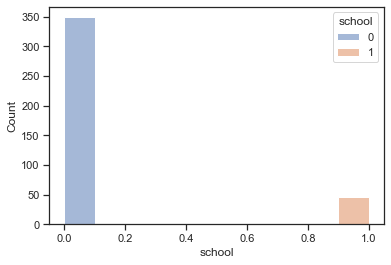

In [32]:
sns.histplot(data=stud_df, x="school",hue="school")

### Father's education Vs. Avgscore
Father's education differentiated by present job of Father and their relationship to student's exam score.
- The FJob = teacher bucket seems to have all students > 10 score that meets our threshold for success.
- All other Fjob buckets have atleast one group that has score < 10 
- Students whose father's are in teh civil services tend to have the lowest mean and lower confidence range. (2nd plot)

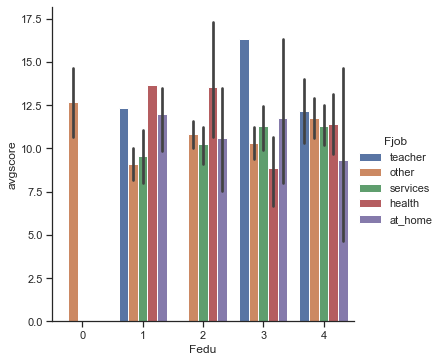

In [35]:
sns.catplot(data=stud_df_orig, kind="bar", x="Fedu", y="avgscore", hue="Fjob")

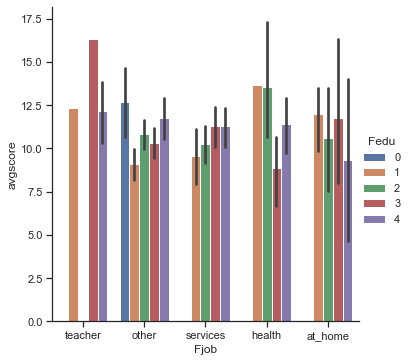

In [36]:
sns.catplot(data=stud_df_orig, kind="bar", x="Fjob", y="avgscore", hue="Fedu")

### Father's education Influence towards Student's desire for Higher education
- Although not surprising, it is an important observation that with Fedu=0 (No education), All students in this buckets wants to do a higher education.
- Otherwise, the common trend in all buckets is to aspire for higher education.  
- Parents with Highest education bucket has lesser cases of not aspiring higher education.
- In other buckets, there is a steady prevalence of not desiring higher education.

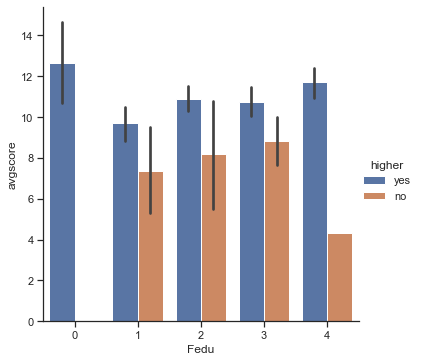

In [39]:
sns.catplot(data=stud_df_orig, kind="bar", x="Fedu", y="avgscore", hue="higher")